# Extracting temperature at specific reefs
**Authors**: Leo Ghignone, Denisse Fierro Arcos  
  
This notebook demonstrates direct access to the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e) dataset in the RIMReP `geoparquet` collection. This dataset includes sea temperature data from 1980 for tropical and subtropical coral reefs around Australia, and it includes sites within the Great Barrier Reef.   
  
In this example, we will extract the coordinates for all sites sampled in this monitoring program and then extract the temperature data for a specific site of interest. This means that we will not need to know the exact location of the site, but we will need to know the name of the site of our interest. 
  
**Note:** The `geoparquet` collection is a compilation of datasets that have been converted to the Apache `parquet` format. This format is designed for efficient storage and retrieval of tabular data. The `geoparquet` collection is stored on the RIMReP S3 bucket and is accessible to all users.

## Loading libraries

In [1]:
# Accessing S3 bucket
import s3fs
# Managing dataframes
from pyarrow import dataset as ds
import pandas as pd
import geopandas as gpd
# Checking patterns in strings using regular expressions (regex)
import re
# Plotting
import matplotlib.pyplot as plt
#Color maps
from matplotlib import colormaps as cmaps

## Inspecting metadata
The AIMS Temperature dataset contains over 150 million records. We will use its metadata to check the structure of the dataset and to determine the best way to access the data.

This is the dataset URI you obtained form the metadata catalog. 

In [2]:
uri = "gbr-dms-data-public/aims-temp-loggers/data.parquet"
s3 = s3fs.S3FileSystem(anon=True)

In [3]:
#Connecting to dataset
dataset = ds.dataset(uri, filesystem=s3)

We can check the structure of the data by calling its `schema` attribute. This will return a list containing the name of the column and its data type.

In [4]:
dataset.schema

deployment_id: int64
site: string
site_id: int64
subsite: string
subsite_id: int64
from_date: timestamp[ns]
thru_date: timestamp[ns]
depth: double
parameter: string
instrument_type: string
serial_num: string
lat: double
lon: double
gbrmpa_reef_id: string
metadata_uuid: string
sites_with_climatology_available: int64
time: timestamp[ns, tz=UTC]
cal_val: double
qc_val: double
qc_flag: int64
geometry: binary
fid: string
-- schema metadata --
pandas: '{"index_columns": ["fid"], "column_indexes": [{"name": null, "fi' + 2827
geo: '{"primary_column": "geometry", "columns": {"geometry": {"encoding":' + 174

The `schema` gives us a list of all 23 columns of the data with their types. It tells us that the data types are `string`, `int`, `double`, or `timestamp`.

If we refer to the original site for the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e), we can see that the `qc_val` column refers to the quality controlled temperature obtained from the loggers deployed as part of this program.

## Connecting to S3 parquet directory
We will connect to the S3 bucket containing the AIMS Temperature dataset using the `dask_geopandas` library. We will only keep sites that have been deployed in the Great Barrier Reef Marine Protected Area (GBRMPA), so we will provide a `filter` that contains the minimum and maximum coordinates (i.e., `lat` and `lon`) of a bounding box around the Great Barrier Reef Marine Protected Area.

As we saw above, this dataset includes 23 columns, but we will only select a few that contain information that is interesting to us:
- `site`: name of site where temperature logger was deployed,
- `subsite`: contains a shorten version of the site name and an indication of where loggers where deployed (see below for more details),
- `geometry`: includes latitude and longitude coordinates in [well-known binary (WKB)](https://loc.gov/preservation/digital/formats/fdd/fdd000549.shtml) format  
  
Based on the `subsite` information, we will create a new column that we will call `deployment_location`. If the `subsite` string in a row includes `SL` it indicates that the temperature logger was deployed on a reef slope (depths of 3 m or more). Thus, our new column will be labelled reef slope. If a row contains `FL` in the `subsite` column, this means the temperature logger was deployed on a reef flat (areas less than 3 m deep). Therefore, we will classify this observation as reef flat in our new column.

Note that when we use the `geopandas` library, the `geometry` field is automatically recognised as coordinates in decimal degrees and used as the `geometry` column in a `GeoDataFrame` object. This means we can use it to plot the data in a map easily.

The following code chunk may take some time to run, as it is querying over 170 million records.

In [5]:
# Extracting data only for specific reefs
filter = ('site', 'in', ['Heron Island', 'Hayman Island'])

sites = gpd.read_parquet(
    uri,
    filters=[filter],
    columns=['site', 'subsite', 'time', 'qc_val', 'geometry'],
    filesystem=s3,
)

# Checking the contents of the dataframe - First five rows
sites.head()

,site,subsite,time,qc_val,geometry
fid,,,,,
Hayman Island-1996-05-29 14:00:00+00:00-2948,Hayman Island,HAYFL1,1996-05-29 14:00:00+00:00,25.21,POINT (148.8819 -20.0413)
Hayman Island-1996-05-29 14:00:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 14:00:00+00:00,24.94,POINT (148.8997 -20.0572)
Hayman Island-1996-05-29 14:30:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 14:30:00+00:00,24.89,POINT (148.8997 -20.0572)
Hayman Island-1996-05-29 14:30:00+00:00-2948,Hayman Island,HAYFL1,1996-05-29 14:30:00+00:00,25.18,POINT (148.8819 -20.0413)
Hayman Island-1996-05-29 15:00:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 15:00:00+00:00,24.85,POINT (148.8997 -20.0572)


## Creating `deployment_location` column
We will use the `subsite` column to create the deployment categories as explained in the section above. If no condition is met, then we will label the row as other.

In [6]:
# Creating new column with deployment location information
sites['deployment_location'] = sites.apply(lambda x: 'reef slope' if bool(re.match('.*(SL[0-9]{1,2})', x.subsite)) == True \
         else ('reef flat' if bool(re.match('.*(FL[0-9]{1,2})', x.subsite)) == True else 'other'), axis = 1)

#Checking results
sites

,site,subsite,time,qc_val,geometry,deployment_location
fid,,,,,,
Hayman Island-1996-05-29 14:00:00+00:00-2948,Hayman Island,HAYFL1,1996-05-29 14:00:00+00:00,25.21,POINT (148.8819 -20.0413),reef flat
Hayman Island-1996-05-29 14:00:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 14:00:00+00:00,24.94,POINT (148.8997 -20.0572),reef slope
Hayman Island-1996-05-29 14:30:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 14:30:00+00:00,24.89,POINT (148.8997 -20.0572),reef slope
Hayman Island-1996-05-29 14:30:00+00:00-2948,Hayman Island,HAYFL1,1996-05-29 14:30:00+00:00,25.18,POINT (148.8819 -20.0413),reef flat
Hayman Island-1996-05-29 15:00:00+00:00-2951,Hayman Island,HAYSL1,1996-05-29 15:00:00+00:00,24.85,POINT (148.8997 -20.0572),reef slope
...,...,...,...,...,...,...
Heron Island-2024-02-04 13:37:00+00:00-498650,Heron Island,HERFL1,2024-02-04 13:37:00+00:00,28.7031,POINT (151.9182 -23.4384),reef flat
Heron Island-2024-02-04 13:42:00+00:00-498650,Heron Island,HERFL1,2024-02-04 13:42:00+00:00,28.6612,POINT (151.9182 -23.4384),reef flat
Heron Island-2024-02-04 13:47:00+00:00-498650,Heron Island,HERFL1,2024-02-04 13:47:00+00:00,28.6134,POINT (151.9182 -23.4384),reef flat


## Extracting data for sites of interest
We can use the information in our `sites` variable to extract data for a site of interest. All we need to know is the name of the site, as shown below.

Here, we will use data collected at **Hayman Island** and **Heron Island** as an example. We will calculate monthly means at each site, so we can plot time series that will show us how temperature has changed over time.

The data frame does only include observations for the sites of our interest. This means we can remove and the columns labelled as "right" from our data frame because they contain the same information as the "left" columns.  
  
We will also calculate the mean monthly temperature at each site and deployment location combination.

In [7]:
# Extracting the year and month for each observation
sites['year'] = sites.time.dt.year.values
sites['month'] = sites.time.dt.month.values
# Ensuring months are two digits - This wil be important for labelling our plots later
sites['month'] = sites.apply(lambda x: str(x.month).zfill(2), axis = 1)

# Calculate mean monthly temperatures for each site and deployment location
sites_temp = sites.groupby(['site', 'deployment_location', 'year', 'month']).mean('qc_val').reset_index()

#Checking results
sites_temp.head()

,site,deployment_location,year,month,qc_val
0,Hayman Island,reef flat,1996,05,25.171466
1,Hayman Island,reef flat,1996,06,24.397491
2,Hayman Island,reef flat,1996,07,23.204402
3,Hayman Island,reef flat,1996,08,22.742272
4,Hayman Island,reef flat,1996,09,23.614451


### Plotting monthly means
Before plotting, we will add a few extra columns that we will use to label and color our plot.

In [8]:
# Adding column with dates for which means were calculated
sites_temp['date_mean'] = pd.to_datetime(sites_temp.year.astype('str') + '-' + sites_temp.month)

# Transforming site column to categorical data
sites_temp['site'] = pd.Categorical(sites_temp.site)

# Changing site categories to numeric values for plotting - We can then change the colors based on this column
sites_temp['colours'] = sites_temp.site.cat.codes

#Checking results
sites_temp.head()

,site,deployment_location,year,month,qc_val,date_mean,colours
0,Hayman Island,reef flat,1996,05,25.171466,1996-05-01,0
1,Hayman Island,reef flat,1996,06,24.397491,1996-06-01,0
2,Hayman Island,reef flat,1996,07,23.204402,1996-07-01,0
3,Hayman Island,reef flat,1996,08,22.742272,1996-08-01,0
4,Hayman Island,reef flat,1996,09,23.614451,1996-09-01,0


Finally, we will create our plot. We will have two subplots based on the `deployment_location` column and the color of the lines and points will vary based on the `site` column.

/tmp/ipykernel_2592796/46233019.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = sites_temp.groupby(['site', 'colours', 'deployment_location'])


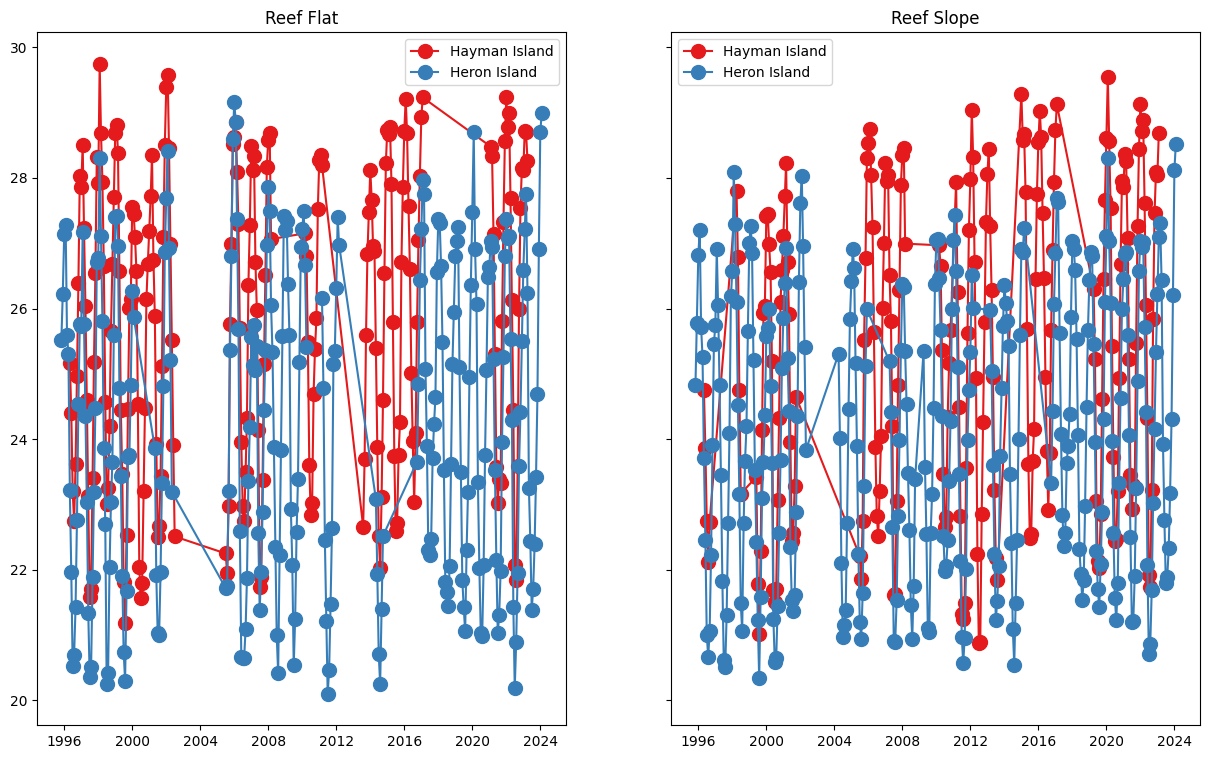

In [9]:
# We group our data by site, colours, and deployment location
groups = sites_temp.groupby(['site', 'colours', 'deployment_location'])

# We select a color map for our plots
cmap = cmaps['Set1']

# We initialise the figure and axes. We also define the size of the figure.
# Axes refer to the subplots in the figure (1 row and 2 columns). They will share the y axis
fig, ax = plt.subplots(1, 2, figsize = (15, 9), sharey = True)

# Now we use our groups to plot the data
# Element here has the categories of the groupby object (site, colours, and deployment location)
# Group has the subset dataframes for each category
for element, group in groups:
    # If the deployment location is reef flat, we plot the data in the first subplot
    if 'flat' in element[2]:
        # Plotting dates in x axis and mean temperature in y axis
        ax[0].plot(group['date_mean'], group['qc_val'], marker = 'o', ms = 10, 
             # We use the site name as the label for each line and the color will change based on the colour column
             label = f'{element[0]}', color = cmap(element[1]))
        # Title for subplot
        ax[0].set_title('Reef Flat')
        # Adding legend
        ax[0].legend()
    # In all other cases, we plot the data in the second subplot
    else:
        #As above
        ax[1].plot(group['date_mean'], group['qc_val'], marker = 'o', ms = 10, 
             label = f'{element[0]}', color = cmap(element[1]))
        ax[1].set_title('Reef Slope')
        ax[1].legend()



If you would like to save the figure, you can use the `savefig` method, as follows: `plt.savefig(file_name)`. Here `file_name` can contain a path to a directory and a file name with the extension of the file type you would like to save the figure as. For example, `plt.savefig('figures/temperature_timeseries.png')` will save the figure in a directory called `figures` and the file name will be `temperature_timeseries.png`.  
  
If you would like to save the data frame, you can use the `to_csv` method, as follows: `sites_temp.to_csv(file_name)`.  
  
That is the end of this notebook. We have demonstrated how to extract data from the AIMS Temperature Logger Monitoring Program dataset and how to plot monthly means for two sites of interest.  